# Identifying tagged neurons

As described in the optotagging section, identifying cells in an electrophysiological recording relies on looking for responses that are precicely synced with the laser stimuli. This notebook will go over how to align responses of recorded units to the laser presentations, calculate some metrics to determine how responsive the unit is, and then perform the same over all units collected during a session in order to assign cell type labels.

## Import required packages
Since the data is packaged as nwb files, you'll need to import hdmf_zarr to interact with the data. The metadata for each experiment is stored as .json files, so you'll want to import json as well.

...and os is just nice for formatting file paths!

In [1]:
from hdmf_zarr import NWBZarrIO
import json
import os
import numpy as np

## Determining identity of laser responsive cells

Every experimental session may have a different set of tagged neurons. The identity of any laser-responsive units can be inferred from the mouse's genotype and viruses injected, both of which can be found in the metadata. A list of the mouse lines used in this data set and what they tag can be found in the optotagging section.

In [2]:
# an 'arbitrarily' selected session
session = '661398_2023-04-03_15-47-29'
session_directory = f'/data/cell_type_lookup_table_nwb/ecephys_{session}_nwb'

nwb_file = os.path.join(session_directory, f'ecephys_{session}_experiment1_recording1.nwb.zarr')
io = NWBZarrIO(nwb_file, "r")
nwbfile_read = io.read()

In [3]:
# subject.json contains info about the mouse, procedures.json contains info about surgeries and such that were performed
subject_json = os.path.join(session_directory, 'subject.json')
procedures_json = os.path.join(session_directory, 'procedures.json')

# load both json files
with open(subject_json, 'r', ) as f:
    subject = json.load(f)
with open(procedures_json, 'r', ) as f:
    procedures = json.load(f)

print(subject['genotype'])

virus_names = []
try:
    for material in procedures['injections'][0]['injection_materials']:
        virus_names.append(material['name'])
except(KeyError):
    for material in procedures['subject_procedures'][2]['injection_materials']: # the procedures scraped from NSB are formatted differently
        virus_names.append(material['name'])

print(virus_names)

Adora2a-Cre/wt
['D1 enhancer CoChR', 'DIO-ChRmine-mScarlet']


So this animal was Adora2a-Cre (meaning it expresses Cre in D2 cells) and it was injected with two viruses: an enhancer delivering CoChR to D1 cells, and a Cre-dependent virus delivering ChRmine. From this, we can conclude that this mouse should express CoChR in D1 cells and ChRmine in D2 cells. Therefore, any cells responding to blue laser pulses are D1 calls, and cells responding to red laser pulses are D2 cells!

## Visualising cell responses

How do we tell if a cell is laser-responsive? We should take a look at the spiking activity during laser presentations. To do this, let's align the spike timestamps to the laser trial timestamps.

In [4]:
units = nwbfile_read.units[:]

In [5]:
# load spike timestamp data for an 'arbitrarily' selected unit
unit_id = 259
spike_timestamps = units.spike_times.loc[unit_id]

In [6]:
# load the stimulus table
stimulus_table = nwbfile_read.intervals['trials'].to_dataframe()
stimulus_table.columns

Index(['start_time', 'stop_time', 'site', 'power', 'param_group',
       'emission_location', 'duration', 'rise_time', 'num_pulses',
       'wavelength', 'type', 'inter_pulse_interval', 'stimulus_template_name'],
      dtype='object')

In [7]:
# select the highest power trials where the light emission was on the same probe the unit is on
unit_device = units.device_name.loc[unit_id]
max_laser_power = max(stimulus_table['power']) # be careful with this in the future, different color lasers are sometimes presented at different powers!

#filtered_stimulus_table = stimulus_table.query('emission_location == @unit_device and power == @max_laser_power')
filtered_stimulus_table = stimulus_table.query('emission_location == @unit_device and power == 0.1')
filtered_stimulus_table

,start_time,stop_time,site,power,param_group,emission_location,duration,rise_time,num_pulses,wavelength,type,inter_pulse_interval,stimulus_template_name
id,,,,,,,,,,,,,
19,8993.010352,8993.050352,4,0.1,train,ProbeA,0.01,0.001,5,638,internal_red,0.04,internal_red-train-0.1mW
60,9009.575600,9009.605600,7,0.1,train,ProbeA,0.01,0.001,5,638,internal_red,0.04,internal_red-train-0.1mW
65,9011.553267,9011.603267,6,0.1,train,ProbeA,0.01,0.001,5,450,internal_blue,0.04,internal_blue-train-0.1mW
73,9014.826554,9014.876554,4,0.1,train,ProbeA,0.01,0.001,5,638,internal_red,0.04,internal_red-train-0.1mW
88,9020.874354,9020.914354,4,0.1,train,ProbeA,0.01,0.001,5,450,internal_blue,0.04,internal_blue-train-0.1mW
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13942,14608.399733,14608.429733,5,0.1,train,ProbeA,0.01,0.001,5,450,internal_blue,0.04,internal_blue-train-0.1mW
13946,14609.996933,14610.036933,6,0.1,train,ProbeA,0.01,0.001,5,450,internal_blue,0.04,internal_blue-train-0.1mW
13964,14617.274400,14617.324400,8,0.1,train,ProbeA,0.01,0.001,5,638,internal_red,0.04,internal_red-train-0.1mW


There's both red and blue laser pulses in this stimulus table. Let's try plotting the unit responses to both to see if either evokes a response. To do this, we'll create a "raster plot": a plot showing the spike times for each trial aligned to an event, in this case the laser onset. As such, we will need to convert the absolute spike times over the course of the whole experiment to relative spike times (relative to laser onset). We can do this with numpy's searchsorted function.

In [8]:
time_range = np.array([-0.1, 0.3]) # time range (in seconds) to plot around each laser onset event

blue_laser_stim_table = filtered_stimulus_table.query('type == "internal_blue"')
laser_onset_timestamps = blue_laser_stim_table.start_time.tolist()

In [9]:
# let's make a function that can convert absolute timestamps to relative timestamps, as this will come in handy a lot!

def event_locked_timestamps(spike_timestamps, event_timestamps, time_range):
    """
    Converts spike timestamps over course of entire session to time stamps relative to an event.

    :param spike_timestamps: 1d array of floats, times a spike occurred over course of session
    :param event_timestamps: 1d array of floats, times an event occurred over course of session
    :param time_range: time range relative to event onset over which to collect spike times for each trial
    :return: event_locked_spike_times: list of arrays (1 per trial), array contains spike times relative to event onset
    for that trial
    """
    Ntrials = len(event_timestamps)

    event_locked_spike_times = []
    for ind_trial in np.arange(Ntrials):
        time_range_this_trial = event_timestamps[ind_trial] + time_range
        spike_inds_this_trial = np.searchsorted(spike_timestamps, time_range_this_trial)
        spike_times_this_trial = spike_timestamps[spike_inds_this_trial[0]:spike_inds_this_trial[1]]
        event_locked_spike_times.append(spike_times_this_trial - event_timestamps[ind_trial])

    return np.array(event_locked_spike_times, dtype=object)

# another useful function to convert timestamps to counts per bin
def timestamps_to_spike_counts(spike_timestamps, bins):
    """
    Converts timestamps at which spikes occurred to spike counts per time bin.
    :param spike_timestamps: should be a list of lists (one list per trial)
    :param bins: time ranges over which to calculate number of spikes
    :return: spike_counts: numpy array, dimensions num trials x len(bins)-1, number of spikes that happened in each time
    bin for each trial
    """
    Ntrials = len(spike_timestamps)
    spike_counts = np.empty((Ntrials, len(bins) - 1))
    for trial in range(Ntrials):
        this_spike_counts, bin_edges = np.histogram(spike_timestamps[trial], bins)
        spike_counts[trial, :] = this_spike_counts

    return spike_counts

In [10]:
laser_locked_spike_timestamps = event_locked_timestamps(spike_timestamps, laser_onset_timestamps, time_range)

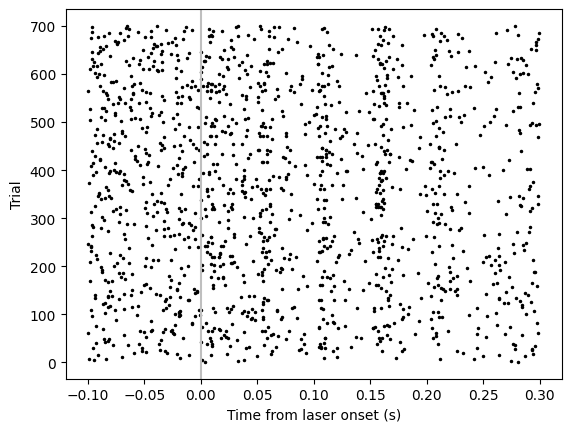

In [11]:
# make a raster plot of all trials!
import matplotlib.pyplot as plt
%matplotlib inline

Ntrials = len(laser_locked_spike_timestamps)
for trial in range(Ntrials):
    this_raster = plt.plot(laser_locked_spike_timestamps[trial], (trial + 1) * np.ones(len(laser_locked_spike_timestamps[trial])), '.', color='k', rasterized=True, ms=3)
plt.ylabel('Trial')
plt.xlabel('Time from laser onset (s)')
plt.axvline(0, color='0.75')

Looks like there might be a weak response... but wait! The NPopto has 14 emission sites, and the trials from all of these are interleaved! Let's try grouping trials by emission site and see if we see anything.

In [12]:
emission_site = np.array(blue_laser_stim_table.site.tolist())

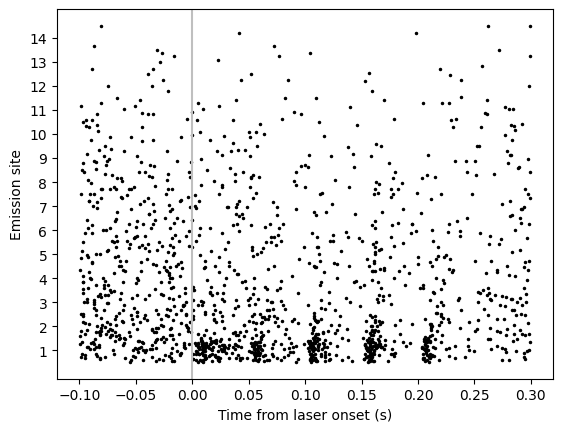

In [17]:
for site in np.unique(emission_site):
    trials_this_site = emission_site == site
    this_laser_locked_timestamps = laser_locked_spike_timestamps[trials_this_site]
    Ntrials = len(this_laser_locked_timestamps)
    for trial in range(Ntrials):
        this_raster = plt.plot(this_laser_locked_timestamps[trial], site * (trial + 1) * np.ones(len(this_laser_locked_timestamps[trial])), '.', color='k', rasterized=True, ms=3)

# set the y labels to be the different emission sites
ax = plt.gca()
y_ticks = 50*np.unique(emission_site)-25 #so each tick is in the middle of the 50 trial range
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.unique(emission_site))
        
plt.ylabel('Emission site')
plt.xlabel('Time from laser onset (s)')
plt.axvline(0, color='0.75')

Definitely a strong response when laser is presented at emission site 1! But how do we quantify it? An obvious answer is to see if the increase in firing rate is statistically significant. Since the laser presentation has five pulses, we can also check how consistent the response is by testing if every pulse has a significant response.

There are 14 emission sites. How do we know which one to select for testing? We could test all 14, then correct for multiple comparisons. Alternatively, we could determine which one elicits the largest increase in firing rate, or the lowest latency response.

In [14]:
# applying the strategy of testing every emission site
from scipy import stats
from statsmodels.stats.multitest import multipletests

pulse_duration = np.unique(blue_laser_stim_table.duration)[0]
first_pulse_time_range = [0, pulse_duration]
baseline_time_range = [-pulse_duration, 0]

first_pulse_counts = timestamps_to_spike_counts(laser_locked_spike_timestamps, first_pulse_time_range)
baseline_counts = timestamps_to_spike_counts(laser_locked_spike_timestamps, baseline_time_range)

all_site_pvals = []
for site in np.unique(emission_site):
    trials_this_site = emission_site == site
    this_site_pulse_counts = first_pulse_counts[trials_this_site]
    this_site_baseline_counts = baseline_counts[trials_this_site]
    
    # paired test
    try:
        statistic, pVal = stats.wilcoxon(this_site_pulse_counts.flatten(),
                                this_site_baseline_counts.flatten(),
                                alternative='greater')
    except(ValueError):  # wilcoxon test doesn't like it when there's no difference between passed values
        statistic = 0
        pVal = 1
        
    all_site_pvals.append(pVal)
    
# corrected pvals
(responsive_sites, corrected_pVals, alphaSidak, alphaBonf) = multipletests(all_site_pvals, method='holm')
responsive_sites

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

Looks like site 1 has a significant response, even after correcting for the 14 comparisons done!

In [15]:
# see how many pulses the unit responds to
num_pulses = np.unique(blue_laser_stim_table.num_pulses)[0]
inter_pulse_interval = np.unique(blue_laser_stim_table.inter_pulse_interval)[0]
pulse_offset = (pulse_duration + inter_pulse_interval)

trials_best_site = emission_site == 1
baseline_counts_best_site = baseline_counts[trials_best_site]

other_pulse_pvals = []

for ind_pulse in range(1,num_pulses):
    this_pulse_time_range = [first_pulse_time_range[0]+ind_pulse*pulse_offset, first_pulse_time_range[1]+ind_pulse*pulse_offset]
    this_pulse_counts = timestamps_to_spike_counts(laser_locked_spike_timestamps, this_pulse_time_range)
    this_pulse_best_site_counts = this_pulse_counts[trials_best_site]
    
    # paired test
    try:
        statistic, pVal = stats.wilcoxon(this_pulse_best_site_counts.flatten(),
                                baseline_counts_best_site.flatten(),
                                alternative='greater')
    except(ValueError):  # wilcoxon test doesn't like it when there's no difference between passed values
        statistic = 0
        pVal = 1
        
    other_pulse_pvals.append(pVal)


In [16]:
(responsive_pulses, corrected_pVals, alphaSidak, alphaBonf) = multipletests(other_pulse_pvals, method='holm')
responsive_pulses

array([ True,  True,  True,  True])

This unit has a significant response to all five blue laser pulses! That means this unit is likely a tagged D1 cell. (Though it would be good to check the responses to red laser as well: this mouse has D2 cells tagged with ChRmine, which has a broad activation spectrum and often responds to both blue and red laser, while CoChR responds to only blue).

There are often other tests applied to determine if a unit is tagged or not, most notably to check the latency of the response to make sure you're not getting indirect inactivation via synaptic transmission, but this is less of a concern here since medium spiny neurons in striatum are GABAergic.

You can now apply these tests to every unit in this session to determine which units are tagged and learn their identities!